# Práctica 4: Entrenamiento de redes neuronales
---
### Autores:
Raúl Murillo Montero - 5º Doble Grado en Ingeniería Informática - Matemáticas   
Miguel Sierra Esteso - 4º Grado en Ingeniería Informática

---
**Fecha de entrega:** 22 de noviembre de 2018, 18.00h

In [146]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
import displayData as disp
import checkNNGradients as checkNNG
#from sklearn.preprocessing import OneHotEncoder
import pandas as pd

## 1. Función de coste
El objetivo de esta primera parte de la práctica es implementar el cálculo de la función de coste
de una red neuronal para un conjunto de ejemplos de entrenamiento.
Se utiliza el mismo conjunto de datos de la práctica 3. El fichero `ex4data1.mat` contiene 5000 ejemplos de entrenamiento
en el formato nativo para matrices de Octave/Matlab.

In [2]:
weights = loadmat('ex4data1.mat')
# se pueden consultar las claves con data.keys()
y = weights['y']
X = weights ['X']
# almacena los datos leídos en X, y

<IPython.core.display.Javascript object>


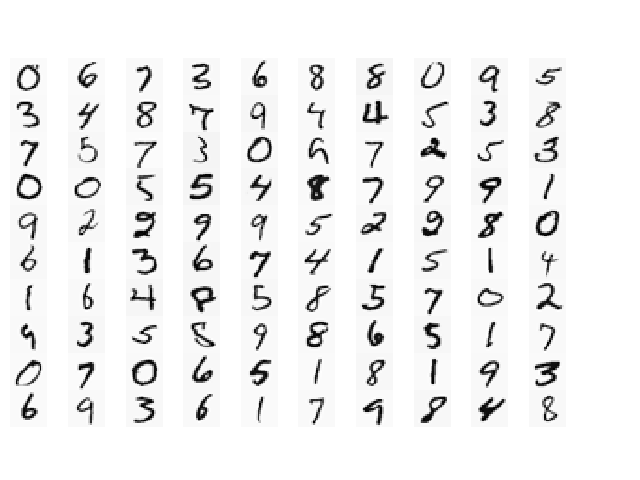

In [3]:
# Selecciona aleatoriamente 100 ejemplos y los pinta
sample = np.random.choice(X.shape[0], 100)
disp.displayData(X[sample])
plt.show()

El fichero `ex4weights.mat` contiene las matrices $\Theta^{(1)}$ y $\Theta^{(2)}$ con el resultado de haber
entrenado la red neuronal y que podemos cargar con la función `scipy.io.loadmat`

In [4]:
weights = loadmat('ex4weights.mat')
theta1,  theta2 = weights ['Theta1'], weights['Theta2']
# Theta1 es de dimensión 25 x 401
# Theta2 es de dimensión 10 x 26

Funciones auxiliares: *sigmoide* y *fordward propagation*.

In [5]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [112]:
def forwardprop(theta1, theta2, X):
    m = X.shape[0]
    # Input layer
    a1 = np.c_[np.ones((m,1)), X] # 5000x401
    # Hidden layer    
    z2 = theta1.dot(a1.T) # 25x401 * 401x5000 = 25x5000 
    a2 = np.c_[np.ones((m,1)),sigmoid(z2.T)] # 5000x26 
    # Output layer
    z3 = theta2.dot(a2.T) # 10x26 * 26x5000 = 10x5000 
    a3 = sigmoid(z3) # 10x5000
    return (a1, z2, a2, z3, a3)

#### Función de coste

In [116]:
def coste(theta1, theta2, X, y):
    m = X.shape[0]
    h = forwardprop(theta1, theta2, X)[4]
    J = -1*(1/m)*np.sum((np.log(h.T)*(y)+np.log(1-h).T*(1-y)))
    return J

In [121]:
# Esta primera versión de la función de coste debería devolver un valor aproximado de 0.287629.
y_matrix = pd.get_dummies(np.array(y).ravel()).values
coste(theta1, theta2, X, y_matrix)

0.2876291651613189

#### Función de coste regularizado

In [122]:
def coste_reg(theta1, theta2, X, y, reg):
    m = X.shape[0]
    J = coste(theta1, theta2, X, y)
    J += (reg/(2*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
    return J

In [123]:
# Con los valores proporcionados para theta1 y theta2, el coste regularizado debería estar en torno a 0.383770.
l = 1
coste_reg(theta1, theta2, X, y_matrix, l)

0.38376985909092365

## 2. Cálculo del gradiente

En esta parte de la práctica has de implementar el algoritmo de retro-propagación para añadir
el cálculo del gradiente a la función `backprop` que ha de devolverlo junto con el coste.

In [124]:
def der_sigmoid(x):
    return np.multiply(sigmoid(x),(1 - sigmoid(x)))

In [125]:
def pesosAleatorios(L_in, L_out):
    eps = 0.12  # it can be assigned by a formula
    # dimension of the matrix is (L_out, 1 + L_in)
    return np.random.uniform(low=-eps, high=eps, size=(L_out, 1 + L_in))    

### 2.1. Retro-propagación

In [154]:
def backprop(params_rn , num_entradas , num_ocultas , num_etiquetas , X, y , reg = 0):
    """
    backprop devuelve el coste y el gradiente de una red neuronal de dos capas
    """
    theta1 = params_rn[:(num_ocultas*(num_entradas+1))].reshape(num_ocultas,(num_entradas+1))
    theta2 = params_rn[(num_ocultas*(num_entradas+1)):].reshape(num_etiquetas,(num_ocultas+1))

    m = X.shape[0]
    y_matrix = pd.get_dummies(np.array(y).ravel()).values
    
    # Cost
    a1, z2, a2, z3, a3 = forwardprop(theta1, theta2, X)
    
    J = coste_reg(theta1, theta2, X, y_matrix, reg)
    
    # Gradients
    d3 = a3.T - y_matrix # 5000x10
    d2 = theta2[:,1:].T.dot(d3.T)*der_sigmoid(z2) # 25x10 *10x5000 * 25x5000 = 25x5000
    
    delta1 = d2.dot(a1) # 25x5000 * 5000x401 = 25x401
    delta2 = d3.T.dot(a2) # 10x5000 *5000x26 = 10x26
    
    theta1_ = np.c_[np.zeros((theta1.shape[0],1)),theta1[:,1:]]
    theta2_ = np.c_[np.zeros((theta2.shape[0],1)),theta2[:,1:]]
    
    theta1_grad = delta1/m + (theta1_*reg)/m
    theta2_grad = delta2/m + (theta2_*reg)/m
    
    return(J, np.r_[theta1_grad.ravel(), theta2_grad.ravel()])

In [157]:
# Backpropagation test
num_entradas , num_ocultas , num_etiquetas = 400, 25, 10
t1 = pesosAleatorios(num_entradas, num_ocultas)
t2 = pesosAleatorios(num_ocultas, num_etiquetas)
params = np.r_[theta1.ravel(), theta2.ravel()]

In [158]:
# Regularization parameter = 0
backprop(params, num_entradas , num_ocultas , num_etiquetas, X, y, 0)[0]

0.2876291651613189

In [159]:
# Regularization parameter = 1
backprop(params, num_entradas , num_ocultas , num_etiquetas, X, y, 1)[0]

0.38376985909092365

### 2.2 Chequeo del gradiente

Con la práctica se ha proporcionado el fichero `checkNNGradients.py` que continene una
funcion que aproxima el valor de la derivada numéricamente.   
Si el gradiente está implementado correctamente, la diferencia
debería ser menor de $10^{−9}$.

In [155]:
# Regularization parameter = 0
checkNNG.checkNNGradients(backprop, 0);
print("OK")

OK


### 2.3. Redes neuronales regularizadas

In [156]:
# Regularization parameter = 1
checkNNG.checkNNGradients(backprop, 1);
print("OK")

OK


## 3. Aprendizaje de los parámetros

Utilizar la función `scipy.optimize.minimize` para entrenar a la red neuronal y obtener los valores para $\Theta^{(1)}$ y
$\Theta^{(2)}$.
Entrenando a la red con 70 iteraciones y un valor de $\lambda = 1$ se debería obtener una precisión en
torno al 93% (puede variar hasta un 1% debido a la inicialización aleatoria de los parámetros).

In [241]:
num_entradas, num_ocultas, num_etiquetas = 400, 25, 10
t1 = pesosAleatorios(num_entradas, num_ocultas)
t2 = pesosAleatorios(num_ocultas, num_etiquetas)
params = np.r_[t1.ravel(), t2.ravel()]
learning_rate = 1
fmin = minimize(fun=backprop, x0=params, args=(num_entradas, num_ocultas, num_etiquetas, X, y, learning_rate), 
                method='TNC', jac=True, options={'maxiter': 70})
fmin

     fun: 0.6543764481121167
     jac: array([-1.07570490e-03, -1.29785632e-05, -1.05889931e-05, ...,
        1.83011953e-04, -1.81584587e-04, -1.18875126e-03])
 message: 'Max. number of function evaluations reached'
    nfev: 70
     nit: 11
  status: 3
 success: False
       x: array([-0.38271292, -0.06489282, -0.05294497, ...,  0.61149437,
        2.70019349,  0.95202838])

In [242]:
Theta1 = fmin.x[:(num_ocultas*(num_entradas+1))].reshape(num_ocultas,(num_entradas+1))
Theta2 = fmin.x[(num_ocultas*(num_entradas+1)):].reshape(num_etiquetas,(num_ocultas+1))

a3 = forwardprop(Theta1, Theta2, X)[4]
# NN's accuracy
n = len(y)
y_pred = np.array(np.argmax(a3, axis=0) + 1)

print('La red neuronal ha clasificado correctamente el {}% de los ejemplos de entrenamiento'
      .format(np.mean(y_pred == y.ravel())*100))

La red neuronal ha clasificado correctamente el 92.08% de los ejemplos de entrenamiento


#### Variación del número de iteraciones

<IPython.core.display.Javascript object>


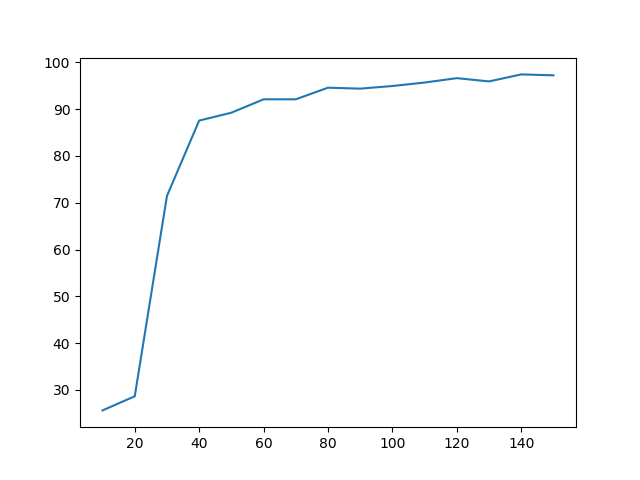

In [243]:
maxiter = range(10, 151, 10)
accuracy = np.empty(len(maxiter))

for i in range(len(maxiter)):
    fmin = minimize(fun=backprop, x0=params, args=(num_entradas, num_ocultas, num_etiquetas, X, y, learning_rate), 
                method='TNC', jac=True, options={'maxiter': maxiter[i]})
    Theta1 = fmin.x[:(num_ocultas*(num_entradas+1))].reshape(num_ocultas,(num_entradas+1))
    Theta2 = fmin.x[(num_ocultas*(num_entradas+1)):].reshape(num_etiquetas,(num_ocultas+1))

    a3 = forwardprop(Theta1, Theta2, X)[4]
    # NN's accuracy
    n = len(y)
    y_pred = np.array(np.argmax(a3, axis=0) + 1)
    accuracy[i] = np.mean(y_pred == y.ravel())*100

# Plotting results
plt.figure()
plt.plot(maxiter, accuracy)
plt.show()

<IPython.core.display.Javascript object>


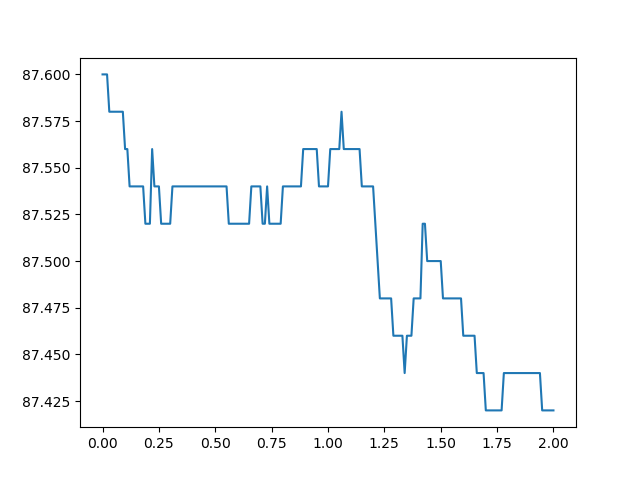

In [266]:
maxiter = 40
l_rate = np.arange(0, 2.01, 0.01)
accuracy = np.empty(len(l_rate))

for i in range(len(l_rate)):
    fmin = minimize(fun=backprop, x0=params, args=(num_entradas, num_ocultas, num_etiquetas, X, y, l_rate[i]), 
                method='TNC', jac=True, options={'maxiter': maxiter})
    Theta1 = fmin.x[:(num_ocultas*(num_entradas+1))].reshape(num_ocultas,(num_entradas+1))
    Theta2 = fmin.x[(num_ocultas*(num_entradas+1)):].reshape(num_etiquetas,(num_ocultas+1))

    a3 = forwardprop(Theta1, Theta2, X)[4]
    # NN's accuracy
    n = len(y)
    y_pred = np.array(np.argmax(a3, axis=0) + 1)
    accuracy[i] = np.mean(y_pred == y.ravel())*100

plt.figure()
plt.plot(l_rate, accuracy)
plt.show()